In [42]:
from python_speech_features import logfbank
import scipy.io.wavfile as wav
import os
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from ignite.metrics import Loss, Accuracy
from ignite.contrib.handlers import ProgressBar
from IPython.display import clear_output
from ignite.handlers import FastaiLRFinder
import matplotlib.pyplot as plt
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
paths = []
labels = []
labels_categorical = []
root = 'SpeechDataset/'

# Iteracja przez katalogi w folderze głównym
for ind, subdir in enumerate(os.listdir(root)):
    subdir_path = os.path.join(root, subdir)
    if not os.path.isdir(subdir_path):
        continue
    for file in os.listdir(os.path.join(root, subdir))[:300]:
        filepath = os.path.join(root, subdir, file)
        if not filepath.endswith('.wav'):
            continue
        paths.append(filepath)
        labels.append(ind)
        labels_categorical.append(subdir)

print(f"Found {len(paths)} WAV files")

# Obliczanie cech logfbank dla każdego sygnału
logfbank_feats = []
for signal_path in paths:
    fs, sig = wav.read(signal_path)
    fbank_feat = logfbank(sig, samplerate=fs)
    logfbank_feats.append(fbank_feat)

# Ustalenie maksymalnej długości sygnału i wyrównanie długości
lengths = [i.shape[0] for i in logfbank_feats]
max_len = np.max(lengths)
print(f"Max length: {max_len}")

# Tworzenie macierzy o ustalonej maksymalnej długości
padded_feats = np.zeros((len(lengths), max_len, logfbank_feats[0].shape[1]), dtype=np.float32)
for i, feats in enumerate(logfbank_feats):
    padded_feats[i, :, :] = np.pad(feats, 
                                    ((int(np.floor((max_len - feats.shape[0]) / 2)),
                                      int(np.ceil((max_len - feats.shape[0]) / 2))),
                                     (0, 0)))

print(f"padded_feats shape: {padded_feats.shape}, dtype: {padded_feats.dtype}")

# Zapisanie wyników do plików
np.save('logfbank_feats.npy', padded_feats)
np.save('labels.npy', labels)
np.save('labels_categorical.npy', labels_categorical)


In [3]:
# Załadowanie danych
feats = np.load('t_logfbank_feats.npy')
labels = np.load('t_labels.npy')

# Przekształcenie danych
feats = feats.reshape(feats.shape[0], -1)
feats = feats.astype(np.float32)

# Podział na zbiory uczący, walidacyjny i testowy
X_train, X_val_test, y_train, y_val_test = train_test_split(    
    feats,
    labels,
    random_state=1,
    stratify=labels,
    train_size=0.8
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val_test,
    y_val_test,
    random_state=1,
    stratify=y_val_test,
    train_size=0.5
)

In [4]:
trainset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
valset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
testset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

In [5]:
train_loader = DataLoader(trainset, batch_size=256)
val_loader = DataLoader(valset, batch_size=256)
test_loader = DataLoader(testset, batch_size=256)

In [6]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # Pierwsza warstwa gęsta
        self.fc2 = nn.Linear(256, 128)   # Druga warstwa gęsta
        self.fc3 = nn.Linear(128, 64)   # Druga warstwa gęsta
        self.fc4 = nn.Linear(64, 42)    # Trzecia warstwa gęsta
        self.dropout1 = nn.Dropout(p = 0.5)  # Pierwsza warstwa dropout (50% prawdopodobieństwo wyłączenia neuronów)
        self.dropout2 = nn.Dropout(p = 0.35)  # Druga warstwa dropout (20% prawdopodobieństwo wyłączenia neuronów)
        self.dropout3 = nn.Dropout(p = 0.2)

    def forward(self, x):
        x = self.fc1(x)  # Przechodzimy przez pierwszą warstwę
        x = self.dropout1(x)  # Zastosowanie dropout po pierwszej warstwie
        x = self.fc2(x)  # Przechodzimy przez drugą warstwę
        x = self.dropout2(x)  # Zastosowanie dropout po drugiej warstwie
        x = self.fc3(x)  # Przechodzimy przez trzecią warstwę
        x = self.dropout3(x)
        x = self.fc4(x)
        return F.log_softmax(x, dim = 1)  # Zastosowanie logarytmu softmax na wyjściu

device = "cuda" if torch.cuda.is_available() else "cpu"  # Sprawdza, czy dostępna jest karta graficzna (GPU), jeśli nie, używa CPU
print(f'CUDA: {torch.cuda.is_available()}')
criterion = nn.NLLLoss()  # Definiuje funkcję strat (strata logarytmiczna z prawdopodobieństw)
# device='cpu'

i_s = X_train.shape[1]

model = Net(i_s)  # Inicjalizuje model sieci neuronowej
model.to(device)  # Przenosi model na odpowiednie urządzenie (GPU lub CPU)
optimizer = optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))  # Definiuje optymalizator SGD z określoną szybkością uczenia i momentem

init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

# Tworzymy obiekt trenera
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

# Tworzymy obiekt ewaluatora
evaluator = create_supervised_evaluator(model, 
                                         metrics={"acc": Accuracy(), 
                                                  "loss": Loss(nn.NLLLoss())}, 
                                         device=device)

# Dodajemy pasek postępu do trenera
ProgressBar(persist=True).attach(trainer, 
                                  output_transform=lambda x: {"batch loss": x})

CUDA: True


/SI/si/lib/python3.11/site-packages/ignite/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
# Walidacja ma być przeprowadzona po zakończeniu każdej epoki
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']))

# Trening modelu przez 150 epok
trainer.run(train_loader, max_epochs=100)

# Ewaluacja modelu na zbiorze testowym
evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)

In [82]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # Reduced number of neurons
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 42)
        self.dropout1 = nn.Dropout(p=0.3)  # Reduced dropout rates
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.1)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Changed activation function to ReLU
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'CUDA: {torch.cuda.is_available()}')
criterion = nn.CrossEntropyLoss()

i_s = X_train.shape[1]

model = Net(i_s)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.999))  # Adjusted learning rate

init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, 
                                         metrics={"acc": Accuracy(), 
                                                  "loss": Loss(nn.CrossEntropyLoss())}, 
                                         device=device)

ProgressBar(persist=True).attach(trainer, 
                                  output_transform=lambda x: {"batch loss": x})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']))

trainer.run(train_loader, max_epochs=150)  # Increased epochs to 150

evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)

{'acc': 0.4148430066603235, 'loss': 2.1631758351421264}


In [ ]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # Reduced number of neurons
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 42)
        self.dropout1 = nn.Dropout(p=0.3)  # Reduced dropout rates
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.1)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Changed activation function to ReLU
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'CUDA: {torch.cuda.is_available()}')
criterion = nn.CrossEntropyLoss()

i_s = X_train.shape[1]

model = Net(i_s)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999))  # Adjusted learning rate

init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, 
                                         metrics={"acc": Accuracy(), 
                                                  "loss": Loss(nn.CrossEntropyLoss())}, 
                                         device=device)

ProgressBar(persist=True).attach(trainer, 
                                  output_transform=lambda x: {"batch loss": x})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']))

trainer.run(train_loader, max_epochs=150)  # Increased epochs to 150

evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)

In [94]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # Reduced number of neurons
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 42)
        self.fc_feedback1 = nn.Linear(64, 256)  # Added feedback layer
        self.dropout1 = nn.Dropout(p=0.3)  # Reduced dropout rates
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.1)

    def forward(self, x):
        x1 = F.relu(self.fc1(x))  # Changed activation function to ReLU
        x1 = self.dropout1(x1)
        x2 = F.relu(self.fc2(x1))
        x2 = self.dropout2(x2)
        x3 = F.relu(self.fc3(x2))
        x3 = self.dropout3(x3)
        x2_feedback = F.relu(self.fc_feedback1(x3)) 
        x2 = F.relu(self.fc2(x2_feedback+x1))
        x2 = self.dropout2(x2)
        x3 = F.relu(self.fc3(x2))
        x3 = self.dropout3(x3)
        x = self.fc4(x3)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'CUDA: {torch.cuda.is_available()}')
criterion = nn.CrossEntropyLoss()

i_s = X_train.shape[1]

model = Net(i_s)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999))  # Adjusted learning rate

init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, 
                                         metrics={"acc": Accuracy(), 
                                                  "loss": Loss(nn.CrossEntropyLoss())}, 
                                         device=device)

ProgressBar(persist=True).attach(trainer, 
                                  output_transform=lambda x: {"batch loss": x})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']))

trainer.run(train_loader, max_epochs=150)  # Increased epochs to 150

evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)

{'acc': 0.5499524262607041, 'loss': 1.676873494737155}


In [7]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 42)
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.1)

    def forward(self, x, x2_temp=0, x3_temp=0):
        x1 = F.relu(self.fc1(x))
        x2 = F.relu(self.fc2(x1+x2_temp))
        x2 = self.dropout2(x2)
        x2_temp = x2
        x3 = F.relu(self.fc3(x2+x3_temp))
        x3 = self.dropout3(x3)
        x3_temp = x3
        x = self.fc4(x3)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'CUDA: {torch.cuda.is_available()}')
criterion = nn.CrossEntropyLoss()

i_s = X_train.shape[1]

model = Net(i_s)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, 
                                         metrics={"acc": Accuracy(), 
                                                  "loss": Loss(nn.CrossEntropyLoss())}, 
                                         device=device)

ProgressBar(persist=True).attach(trainer, 
                                  output_transform=lambda x: {"batch loss": x})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']))

trainer.run(train_loader, max_epochs=150)

evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)

{'acc': 0.6608996539792388, 'loss': 1.1662728596723615}


In [101]:
# Zakres wartości wejściowych
x = np.linspace(-5.0, 10.0, 10)

# Funkcje aktywacji
relu = F.relu(torch.tensor(x)).numpy()
sigmoid = torch.sigmoid(torch.tensor(x)).numpy()
tanh = torch.tanh(torch.tensor(x)).numpy()
leaky_relu = F.leaky_relu(torch.tensor(x), negative_slope=0.01).numpy()
softmax = F.softmax(torch.tensor(x), dim=0).numpy()
log_softmax = F.log_softmax(torch.tensor(x), dim=0).numpy()

fig = make_subplots(rows=2, cols=3, subplot_titles=("ReLU", "Sigmoid", "Tanh", "Leaky ReLU", "Softmax", "Log Softmax"))

# Dodawanie wykresów
fig.add_trace(go.Scatter(x=x, y=relu, mode='lines', name='ReLU'), row=1, col=1)
fig.add_trace(go.Scatter(x=x, y=sigmoid, mode='lines', name='Sigmoid'), row=1, col=2)
fig.add_trace(go.Scatter(x=x, y=tanh, mode='lines', name='Tanh'), row=1, col=3)
fig.add_trace(go.Scatter(x=x, y=leaky_relu, mode='lines', name='Leaky ReLU'), row=2, col=1)
fig.add_trace(go.Scatter(x=x, y=softmax, mode='lines', name='Softmax'), row=2, col=2)
fig.add_trace(go.Scatter(x=x, y=log_softmax, mode='lines', name='Log Softmax'), row=2, col=3)

# Aktualizacja układu
fig.update_layout(height=600, width=900, title_text="Funkcje Aktywacji", showlegend=False,
                  yaxis1=dict(range=[-0.1,10]),
                  yaxis2=dict(range=[0,1.2]),
                  yaxis3=dict(range=[-1.5,1.5]),
                    yaxis4=dict(range=[-1,1]),
                    yaxis5=dict(range=[-0.1,2]),
                    yaxis6=dict(range=[-15,1]))

fig.show()

In [20]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 42)
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.1)

    def forward(self, x, x2_temp=0, x3_temp=0):
        x1 = F.softmax(self.fc1(x))
        x2 = F.softmax(self.fc2(x1+x2_temp))
        x2 = self.dropout2(x2)
        x2_temp = x2
        x3 = F.softmax(self.fc3(x2+x3_temp))
        x3 = self.dropout3(x3)
        x3_temp = x3
        x = self.fc4(x3)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'CUDA: {torch.cuda.is_available()}')
criterion = nn.CrossEntropyLoss()

i_s = X_train.shape[1]

model = Net(i_s)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, 
                                         metrics={"acc": Accuracy(), 
                                                  "loss": Loss(nn.CrossEntropyLoss())}, 
                                         device=device)

ProgressBar(persist=True).attach(trainer, 
                                  output_transform=lambda x: {"batch loss": x})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']))

trainer.run(train_loader, max_epochs=150)

evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)

{'acc': 0.05190311418685121, 'loss': 3.367358778587262}


In [8]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 42)
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.1)

    def forward(self, x, x2_temp=0, x3_temp=0):
        x1 = torch.sigmoid(self.fc1(x))
        x2 = torch.sigmoid(self.fc2(x1+x2_temp))
        x2 = self.dropout2(x2)
        x2_temp = x2
        x3 = torch.sigmoid(self.fc3(x2+x3_temp))
        x3 = self.dropout3(x3)
        x3_temp = x3
        x = self.fc4(x3)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'CUDA: {torch.cuda.is_available()}')
criterion = nn.CrossEntropyLoss()

i_s = X_train.shape[1]

model = Net(i_s)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, 
                                         metrics={"acc": Accuracy(), 
                                                  "loss": Loss(nn.CrossEntropyLoss())}, 
                                         device=device)

ProgressBar(persist=True).attach(trainer, 
                                  output_transform=lambda x: {"batch loss": x})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']))

trainer.run(train_loader, max_epochs=150)

evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)

{'acc': 0.2491349480968858, 'loss': 2.3500845622026385}


In [9]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 42)
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.1)

    def forward(self, x, x2_temp=0, x3_temp=0):
        x1 = torch.tanh(self.fc1(x))
        x2 = torch.tanh(self.fc2(x1+x2_temp))
        x2 = self.dropout2(x2)
        x2_temp = x2
        x3 = torch.tanh(self.fc3(x2+x3_temp))
        x3 = self.dropout3(x3)
        x3_temp = x3
        x = self.fc4(x3)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'CUDA: {torch.cuda.is_available()}')
criterion = nn.CrossEntropyLoss()

i_s = X_train.shape[1]

model = Net(i_s)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, 
                                         metrics={"acc": Accuracy(), 
                                                  "loss": Loss(nn.CrossEntropyLoss())}, 
                                         device=device)

ProgressBar(persist=True).attach(trainer, 
                                  output_transform=lambda x: {"batch loss": x})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']))

trainer.run(train_loader, max_epochs=150)

evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)

{'acc': 0.4411764705882353, 'loss': 1.7960610571204585}


In [49]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 42)
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.1)

    def forward(self, x, x2_temp=0, x3_temp=0):
        x1 = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x2 = F.leaky_relu(self.fc2(x1+x2_temp), negative_slope=0.01)
        x2 = self.dropout2(x2)
        x2_temp = x2
        x3 = F.leaky_relu(self.fc3(x2+x3_temp), negative_slope=0.01)
        x3 = self.dropout3(x3)
        x3_temp = x3
        x = self.fc4(x3)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'CUDA: {torch.cuda.is_available()}')
criterion = nn.CrossEntropyLoss()

i_s = X_train.shape[1]

model = Net(i_s)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.8, 0.888))

init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, 
                                         metrics={"acc": Accuracy(), 
                                                  "loss": Loss(nn.CrossEntropyLoss())}, 
                                         device=device)

ProgressBar(persist=True).attach(trainer, 
                                  output_transform=lambda x: {"batch loss": x})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']))

trainer.run(train_loader, max_epochs=150)

evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)

{'acc': 0.6418685121107266, 'loss': 1.250391554254974}


In [17]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 42)
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.1)

    def forward(self, x, x2_temp=0, x3_temp=0):
        x1 = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x2 = F.leaky_relu(self.fc2(x1+x2_temp), negative_slope=0.01)
        x2 = self.dropout2(x2)
        x2_temp = x2
        x3 = F.leaky_relu(self.fc3(x2+x3_temp), negative_slope=0.01)
        x3 = self.dropout3(x3)
        x3_temp = x3
        x = self.fc4(x3)
        return F.log_softmax(x, dim=1)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'CUDA: {torch.cuda.is_available()}')
criterion = nn.NLLLoss()

i_s = X_train.shape[1]

model = Net(i_s)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, 
                                         metrics={"acc": Accuracy(), 
                                                  "loss": Loss(nn.NLLLoss())}, 
                                         device=device)

ProgressBar(persist=True).attach(trainer, 
                                  output_transform=lambda x: {"batch loss": x})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']))

trainer.run(train_loader, max_epochs=150)

evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)

{'acc': 0.6591695501730104, 'loss': 1.27322620009056}


In [21]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 42)
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.1)

    def forward(self, x, x2_temp=0, x3_temp=0):
        x1 = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x2 = F.leaky_relu(self.fc2(x1+x2_temp), negative_slope=0.01)
        x2 = self.dropout2(x2)
        x2_temp = x2
        x3 = F.leaky_relu(self.fc3(x2+x3_temp), negative_slope=0.01)
        x3 = self.dropout3(x3)
        x3_temp = x3
        x = self.fc4(x3)
        return F.log_softmax(x, dim=1)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'CUDA: {torch.cuda.is_available()}')
criterion = nn.NLLLoss2d()

i_s = X_train.shape[1]

model = Net(i_s)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, 
                                         metrics={"acc": Accuracy(), 
                                                  "loss": Loss(nn.NLLLoss2d())}, 
                                         device=device)

ProgressBar(persist=True).attach(trainer, 
                                  output_transform=lambda x: {"batch loss": x})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']))

trainer.run(train_loader, max_epochs=150)

evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)

{'acc': 0.6505190311418685, 'loss': 1.164308118985186}


In [25]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 42)
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.1)

    def forward(self, x, x2_temp=0, x3_temp=0):
        x1 = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x2 = F.leaky_relu(self.fc2(x1+x2_temp), negative_slope=0.01)
        x2 = self.dropout2(x2)
        x2_temp = x2
        x3 = F.leaky_relu(self.fc3(x2+x3_temp), negative_slope=0.01)
        x3 = self.dropout3(x3)
        x3_temp = x3
        x = self.fc4(x3)
        return F.log_softmax(x, dim=1)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'CUDA: {torch.cuda.is_available()}')
criterion = nn.MultiMarginLoss()

i_s = X_train.shape[1]

model = Net(i_s)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, 
                                         metrics={"acc": Accuracy(), 
                                                  "loss": Loss(nn.MultiMarginLoss())}, 
                                         device=device)

ProgressBar(persist=True).attach(trainer, 
                                  output_transform=lambda x: {"batch loss": x})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']))

trainer.run(train_loader, max_epochs=150)

evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)

{'acc': 0.6089965397923875, 'loss': 0.08576010997732618}


In [27]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 42)
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.1)

    def forward(self, x, x2_temp=0, x3_temp=0):
        x1 = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x2 = F.leaky_relu(self.fc2(x1+x2_temp), negative_slope=0.01)
        x2 = self.dropout2(x2)
        x2_temp = x2
        x3 = F.leaky_relu(self.fc3(x2+x3_temp), negative_slope=0.01)
        x3 = self.dropout3(x3)
        x3_temp = x3
        x = self.fc4(x3)
        return F.log_softmax(x, dim=1)
    
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'CUDA: {torch.cuda.is_available()}')
criterion = FocalLoss(alpha=1, gamma=2, reduction='mean')

i_s = X_train.shape[1]

model = Net(i_s)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, 
                                         metrics={"acc": Accuracy(), 
                                                  "loss": Loss(FocalLoss(alpha=1, gamma=2, reduction='mean'))}, 
                                         device=device)

ProgressBar(persist=True).attach(trainer, 
                                  output_transform=lambda x: {"batch loss": x})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']))

trainer.run(train_loader, max_epochs=150)

evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)

{'acc': 0.6539792387543253, 'loss': 0.8594459612889274}


In [32]:
from ignite.engine import Engine
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 42)
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.1)

    def forward(self, x, x2_temp=0, x3_temp=0):
        x1 = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x2 = F.leaky_relu(self.fc2(x1+x2_temp), negative_slope=0.01)
        x2 = self.dropout2(x2)
        x2_temp = x2
        x3 = F.leaky_relu(self.fc3(x2+x3_temp), negative_slope=0.01)
        x3 = self.dropout3(x3)
        x3_temp = x3
        x = self.fc4(x3)
        return F.log_softmax(x, dim=1)

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'CUDA: {torch.cuda.is_available()}')
criterion = LabelSmoothingLoss(classes=42, smoothing=0.1)

i_s = X_train.shape[1]

model = Net(i_s)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

def train_step(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_step)
evaluator = create_supervised_evaluator(model, 
                                         metrics={"acc": Accuracy(), 
                                                  "loss": Loss(LabelSmoothingLoss(classes=42, smoothing=0.1))}, 
                                         device=device)

ProgressBar(persist=True).attach(trainer, 
                                  output_transform=lambda x: {"batch loss": x})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']))

trainer.run(train_loader, max_epochs=150)

evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)

{'acc': 0.6764705882352942, 'loss': 1.6449754972358888}


[1/19]   5%|5          [00:00<?]

Validation Results - Epoch: 1 Avg accuracy: 0.68 Avg loss: 1.23


[1/19]   5%|5          [00:00<?]

Validation Results - Epoch: 2 Avg accuracy: 0.69 Avg loss: 1.21


[1/19]   5%|5          [00:00<?]

Validation Results - Epoch: 3 Avg accuracy: 0.68 Avg loss: 1.21


[1/19]   5%|5          [00:00<?]

Validation Results - Epoch: 4 Avg accuracy: 0.69 Avg loss: 1.20


[1/19]   5%|5          [00:00<?]

Validation Results - Epoch: 5 Avg accuracy: 0.68 Avg loss: 1.22


[1/19]   5%|5          [00:00<?]

Validation Results - Epoch: 6 Avg accuracy: 0.66 Avg loss: 1.23


[1/19]   5%|5          [00:00<?]

Validation Results - Epoch: 7 Avg accuracy: 0.67 Avg loss: 1.26


[1/19]   5%|5          [00:00<?]

/SI/si/lib/python3.11/site-packages/ignite/handlers/lr_finder.py:514: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(cache_filepath.as_posix())


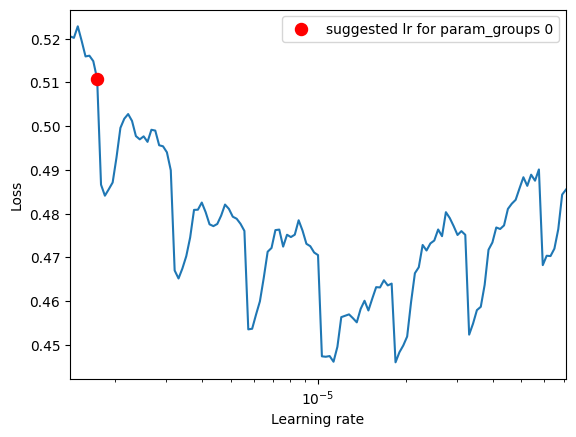

Suggested LR: 1.7378008287493753e-06


In [11]:
# Inicjalizacja obiektu FastaiLRFinder
lr_finder = FastaiLRFinder()

# Przygotowanie słownika z modelem i optymalizatorem
to_save = {'model': model, 'optimizer': optimizer}

# Dołączenie lr_finder do trenera i ustawienie wartości diverge_th na 1.1
with lr_finder.attach(trainer, to_save, diverge_th=1.1, start_lr=1e-6, end_lr=100.0, num_iter=600) as trainer_with_lr_finder:
    # Domyślnie start_lr jest taki, jak określono w obiekcie optimizer, 
    # a end_lr = 10
    trainer_with_lr_finder.run(train_loader)

# Pobranie wyników po zakończeniu poszukiwań najlepszego LR
results = lr_finder.get_results()

# Wykres przedstawiający wyniki
lr_finder.plot()

# Wyświetlenie sugerowanego współczynnika uczenia
print("Suggested LR:", lr_finder.lr_suggestion())


In [12]:
# Utworzenie obiektów trainer i evaluator
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(
    model,
    metrics={"acc": Accuracy(), "loss": Loss(nn.CrossEntropyLoss())},
    device=device
)

# Dodanie paska postępu do trenera
ProgressBar(persist=True).attach(
    trainer, output_transform=lambda x: {"batch loss": x}
)

# Funkcja walidacji po zakończeniu epoki
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)  # Przeprowadzenie walidacji
    metrics = evaluator.state.metrics
    print(f"Validation Results - Epoch: {trainer.state.epoch} "
          f"Avg accuracy: {metrics['acc']:.2f} "
          f"Avg loss: {metrics['loss']:.2f}")
    
    # Zastosowanie sugerowanego współczynnika uczenia
    lr_finder.apply_suggested_lr(optimizer)
    print(f'Training with suggested lr: {optimizer.param_groups[0]["lr"]}')

# Rozpoczęcie treningu
trainer.run(train_loader, max_epochs=50)

# Ewaluacja na zbiorze testowym
evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)


{'acc': 0.7041522491349481, 'loss': 1.0809935467465939}


In [ ]:
import numpy as np

def skok(x):
  if (x >= 0):
    return 1
  else:
    return 0

num_epochs = 10
alpha = 0.75

x = np.array([[0,0,0], [0,1,0], [1,0,0], [1,1,1]])
input_data = x[:, 0:2]
results_data = x[:, 2:]

x0 = np.ones(4)

print(input_data)
input_data = np.c_[x0, input_data]
print(input_data)

weights = np.random.uniform(0,1,3)

for i in range(num_epochs):
  print('EPOKA', i+1)
  for i in range(input_data.shape[0]):
    s = input_data[i].dot(weights)
    result = skok(s)

    if (result != results_data[i]):
      print('błąd')
      weights = weights - alpha * (result - results_data[i]) * input_data[i]
      print('nowe wagi:', weights)
    else:
      print('poprawnie')

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.contrib.handlers import ProgressBar
from IPython.display import clear_output

class TransformerNet(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_encoder_layers, num_decoder_layers):
        super(TransformerNet, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, batch_first=True)
        self.fc1 = nn.Linear(d_model, 128)
        self.fc2 = nn.Linear(128, 42)
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x = self.transformer(x, x)
        x = x.mean(dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'CUDA: {torch.cuda.is_available()}')
criterion = nn.CrossEntropyLoss()

input_size = X_train.shape[1]  # Example for sequence data
d_model = 128
nhead = 8
num_encoder_layers = 2
num_decoder_layers = 2
model = TransformerNet(input_size, d_model, nhead, num_encoder_layers, num_decoder_layers)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, 
                                         metrics={"acc": Accuracy(), 
                                                  "loss": Loss(nn.CrossEntropyLoss())}, 
                                         device=device)

ProgressBar(persist=True).attach(trainer, 
                                  output_transform=lambda x: {"batch loss": x})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']))

trainer.run(train_loader, max_epochs=150)

evaluator.run(test_loader)
clear_output()
print(evaluator.state.metrics)

{'acc': 0.028544243577545196, 'loss': nan}
